In [3]:
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit import SimDivFilters

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# First collect the data we'll be working with and validation sets

In [4]:
# lets use the 37K+PK data as our training data
df = pd.read_csv('../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/TRAIN_03_19_2022.csv')

# we'll hold out a random set from here for testing - 20% test set will be sufficient since it is random and class balanced
# so for testing, use '../data/TEST_03_19_2022.csv'

# we'll also test on all the validation molecules we have predicted on since their scaffolds are quite different- easy,med,hard,molport
# so for testing, use '../data/cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv'
df

,Name,SMILES,hit
0,BRD-K93123848,Cn1c(nc2cc(ccc12)Oc1ccnc(c1)-c1ncc([nH]1)C(F)(...,1.0
1,BRD-K30309936,C[C@H]1CCCCO[C@H](CN(C)Cc2ccc(cc2)C(F)(F)F)[C@...,1.0
2,TRIMETHADIONE,CN1C(=O)OC(C)(C)C1=O,1.0
3,BRD-K76424103,C[C@]1([C@@H](N(Cc2ccccc2)C(=O)c2ccccc21)c1ccc...,1.0
4,BRD-K65130196,CC(C)(C)NCCCCOc1ccc(cc1C(C)(C)C)Cl,1.0
...,...,...,...
30962,BRD-K24978625,N[C@@H]1CC[C@@H](CCn2cc(nn2)C2CCCCC2)O[C@H]1CO,0.0
30963,BRD-K16976282,C[C@H]1CCCCO[C@H](CN(C)S(=O)(=O)C)[C@@H](C)CN(...,0.0
30964,BRD-K53638538,O[C@@H]1CCCC[C@H]1O,0.0
30965,BRD-K77119472,CO[C@@H]1CN(C)C(=O)c2cc(ccc2OC[C@H](C)N(C[C@@H...,0.0


# Let's split into sets where we have different proportions of positive:negative data

Positive samples: 1017.0
Negative samples: 29950.0
Negative to positive ratio: 29.449360865290068
Number of negatives to test: [508, 1017, 2034, 4068, 8136, 16272, 29950]
Number of positives to test: [17, 34, 69, 138, 276, 552, 1017]


[20:47:44] Unusual charge on atom 0 number of radical electrons set to zero
100%|██████████| 29950/29950 [00:03<00:00, 8017.86it/s]


Testing with 17 positives and 508 negatives


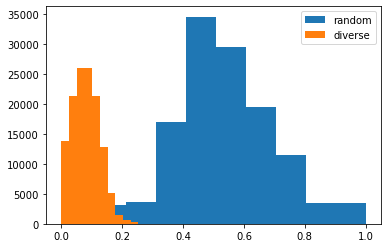

Testing with 34 positives and 1017 negatives


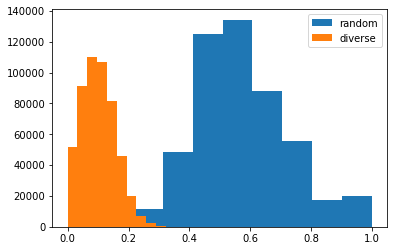

Testing with 69 positives and 2034 negatives


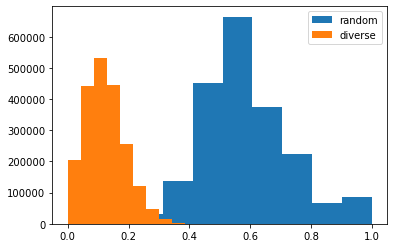

Testing with 138 positives and 4068 negatives


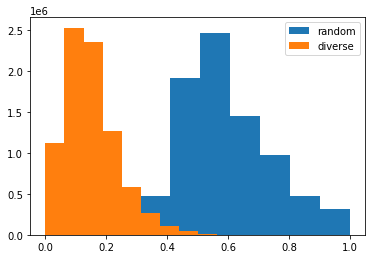

Testing with 276 positives and 8136 negatives


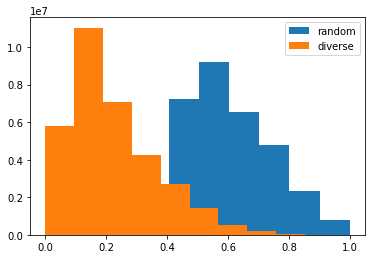

Testing with 552 positives and 16272 negatives


In [ ]:
# Original negative sample sizes
num_neg = [508, 1017, 2034, 4068, 8136, 16272, 29950]

# Calculate the ratio of negative to positive in the original dataframe
total_pos = sum(df['hit'])
total_neg = len(df) - total_pos
neg_to_pos_ratio = total_neg / total_pos

print('Positive samples:', total_pos)
print('Negative samples:', total_neg)
print('Negative to positive ratio:', neg_to_pos_ratio)

# Calculate the corresponding number of positive samples for each dataset size
num_pos = [int(neg / neg_to_pos_ratio) for neg in num_neg]

assert all(abs((neg / pos) - neg_to_pos_ratio) < 0.5 for neg, pos in zip(num_neg, num_pos)), \
    "Positive-to-negative ratio in subsets does not match the original ratio!"

print('Number of negatives to test:', num_neg)
print('Number of positives to test:', num_pos)

out_dir = '../out/experiment_to_test_different_negative_datasets_class_balanced/'

# Preprocess positive and negative data
negative_options = df[df['hit'] == 0.0]
positive_options = df[df['hit'] == 1.0]

all_neg_fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)) for smi in list(negative_options['SMILES'])]
all_pos_fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)) for smi in list(positive_options['SMILES'])]

# Preprocess sorted indices for second method of selection (most similar to positive)
tan_sims_from_all_neg_to_pos = [
    max(DataStructs.BulkTanimotoSimilarity(query_fp, all_pos_fps)) for query_fp in tqdm.tqdm(all_neg_fps)
]
sorted_indices_most_similar = np.argsort([1.0 - x for x in tan_sims_from_all_neg_to_pos])  # Most similar to least similar

for neg_count, pos_count in zip(num_neg, num_pos):
    print(f'Testing with {pos_count} positives and {neg_count} negatives')

    # First method: random negatives
    rand_neg = negative_options.sample(n=neg_count, replace=False)
    rand = pd.concat([rand_neg, positive_options.sample(n=pos_count)]).sample(frac=1)
    rand.to_csv(out_dir + f'random_pos_{pos_count}_neg_{neg_count}.csv', index=False)

    # Second method: most similar negatives
    set_of_sorted_similar_indices = sorted_indices_most_similar[:neg_count]
    similar_neg = negative_options.iloc[set_of_sorted_similar_indices]
    similar = pd.concat([similar_neg, positive_options.sample(n=pos_count)]).sample(frac=1)
    similar.to_csv(out_dir + f'similar_pos_{pos_count}_neg_{neg_count}.csv', index=False)

    # # for proof that it's kinda random: 
    # dist_hist=[]
    # for i in range(len(set_of_sorted_similar_indices)):
    #     for j in range(i+1,len(set_of_sorted_similar_indices)):
    #         dist_hist.append(DataStructs.TanimotoSimilarity(all_neg_fps[set_of_sorted_similar_indices[i]],all_neg_fps[set_of_sorted_similar_indices[j]]))
    # plt.hist(dist_hist, label = 'random')

    # Third method: most diverse negatives
    mmp = SimDivFilters.MaxMinPicker()
    diverse_indices = mmp.LazyBitVectorPick(all_neg_fps, len(all_neg_fps), neg_count)
    diverse_neg = negative_options.iloc[diverse_indices]
    diverse = pd.concat([diverse_neg, positive_options.sample(n=pos_count)]).sample(frac=1)
    diverse.to_csv(out_dir + f'diverse_pos_{pos_count}_neg_{neg_count}.csv', index=False)
    
    # # for proof that it's diverse: 
    # dist_hist=[]
    # for i in range(len(diverse_indices)):
    #     for j in range(i+1,len(diverse_indices)):
    #         dist_hist.append(DataStructs.TanimotoSimilarity(all_neg_fps[diverse_indices[i]],all_neg_fps[diverse_indices[j]]))
    # plt.hist(dist_hist, label = 'diverse')
    # plt.legend()
    # plt.show()
    

# Prep script to train models on these different datasets

In [7]:
bash_dir = 'experiment_to_test_diff_neg_datasets_train_models_class_balanced.sh'

for neg_count, pos_count in zip(num_neg, num_pos):
    for j in ['random', 'similar', 'diverse']:
        # Skip non-random methods for the largest dataset
        if neg_count == len(df) - pos and j != 'random':
            continue
        
        # Updated clean_name to include both positive and negative counts
        clean_name = f"{j}_pos_{pos_count}_neg_{neg_count}"
        
        # Updated folder and file paths to use the new naming convention
        fold = f'models/experiment_with_diff_neg_datasets_class_balanced/{clean_name}/'
        mk_folder_command = f'mkdir -p {fold}'  # Use -p to avoid errors if the folder exists
        train_command = (
            f'chemprop_train --dropout 0.1 --hidden_size 500 --ffn_num_layers 2 --depth 3 '
            f'--metric prc-auc --extra_metrics auc --save_dir {fold} '
            f'--data_path out/experiment_to_test_different_negative_datasets_class_balanced/{clean_name}.csv '
            f'--dataset_type classification --features_generator rdkit_2d_normalized --no_features_scaling '
            f'--num_folds 5 --ensemble_size 2 --split_type scaffold_balanced --split_sizes 0.8 0.1 0.1 '
            f'--smiles_columns SMILES --target_columns hit --gpu 0'
        )
        
        # Write the commands to the bash script
        with open(bash_dir, "a") as file1:
            file1.write(mk_folder_command + '; ' + train_command + '\n')


# Use different neg dataset models to predict on 20% random test set + external val set

In [ ]:
activate_command = 'conda activate chemprop; '
out_path = '../melis_gonorrhea/out/experiment_to_test_different_negative_datasets_class_balanced/'
num_neg = [508, 1017, 2034, 4068, 8136, 16272, 29950]

for neg_count, pos_count in zip(num_neg, num_pos):  # Use num_pos calculated earlier
    for j in ['random', 'similar', 'diverse']:
        for data_name, data in zip(['external_val', '20%_random_test'], 
                                   ['cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv', 
                                    'TEST_03_19_2022.csv']):
            # Updated clean_name to include both positive and negative counts
            clean_name = f"{j}_pos_{pos_count}_neg_{neg_count}"
            try:
                # Updated file path to reflect the new naming convention
                testdf = pd.read_csv(
                    f'../out/experiment_to_test_different_negative_datasets_class_balanced/pred_{data_name}_{clean_name}.csv'
                )
                continue  # already exists
            except FileNotFoundError:
                print(clean_name, data)
                run_command = (
                    f'python predict.py --test_path {out_path}{data} '
                    f'--checkpoint_dir ../melis_gonorrhea/models/experiment_with_diff_neg_datasets_class_balanced/{clean_name}/ '
                    f'--preds_path {out_path}pred_{data_name}_{clean_name}.csv '
                    f'--features_generator rdkit_2d_normalized --no_features_scaling --smiles_column SMILES '
                    f'--ensemble_variance --gpu 0'
                )
                full_command = activate_command + run_command
                test = subprocess.run(full_command, cwd="../../chemprop/", shell=True, capture_output=True)


# Quantify predictions

In [4]:
def modeleval(y_true, y_pred, name = ''):
    
    # Compute auROC 
    auroc = float(roc_auc_score(y_true, y_pred))
    
    # Compute Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr = float(auc(recall,precision))

    return(auroc, pr)

In [10]:
data_dir = '../out/experiment_to_test_different_negative_datasets_class_balanced/'
columns = ['N (negatives)', 'Data Selection', 'Test Set', 'Metric', 'Value']
results = pd.DataFrame(columns=columns)
num_neg = [508, 1017, 2034, 4068, 8136, 16272, 29950]

for neg_count, pos_count in zip(num_neg, num_pos):  # Use num_pos calculated earlier
    for j in ['random', 'similar', 'diverse']:
        for data_name, data in zip(['external_val', '20%_random_test'], 
                                   ['cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv', 
                                    'TEST_03_19_2022.csv']):
            # Updated clean_name to include both positive and negative counts
            clean_name = f"{j}_pos_{pos_count}_neg_{neg_count}"
            
            true_path = f"{data_dir}{data}"
            pred_path = f"{data_dir}pred_{data_name}_{clean_name}.csv"
            
            try:
                true = pd.read_csv(true_path)
                true = list(true['hit'])

                test = pd.read_csv(pred_path)
                test = list(test['hit'])
            except FileNotFoundError:
                continue

            # Calculate metrics
            roc, pr = modeleval(true, test)
            
            # Prepare rows for results
            row1 = [neg_count, j, data_name, 'auROC', roc]
            row2 = [neg_count, j, data_name, 'auPR', pr]
            new = pd.DataFrame([row1, row2], columns=columns)
            
            # Append results
            results = pd.concat([results, new], ignore_index=True)

In [ ]:
# rename for plotting
results['Test Set'] = ['Restricted Similarity' if x=='external_val' else 'Random (20%)' for x in list(results['Test Set'])]
results

In [ ]:
fig_path = '../figure_panels/negative_dataset_example_class_balanced'
results = results.reset_index(drop = True)
order = ['random', 'similar', 'diverse']
palette = dict(zip(order, ['grey', 'lightsteelblue', 'royalblue']))
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.FacetGrid(results, row = 'Metric', col = 'Test Set', sharey = True, height=4, aspect=1.5, margin_titles=True)
g.map(sns.lineplot, 'N (negatives)', 'Value', 'Data Selection', marker = 'o', dashes=True, hue_order = order, palette = palette)

for ax in g.axes_dict.values():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
g.set(xscale='log')
g.set(xticks=num_neg)
g.set(xticklabels=num_neg)
plt.legend()
plt.tight_layout()
plt.savefig(fig_path + '.png')
plt.savefig(fig_path + '.svg')  
plt.show()